In [1]:
# System
import os

# Data processing
import numpy as np
import pandas as pd
import math as m
import datetime as dt

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [2]:
SAVE_INFO = True

In [3]:
if (SAVE_INFO == True):
    DATA_DIR = 'Experiments/'
    EXPERIMENT_DIR = DATA_DIR + 'LSTM_new_metrics_1_th=5/'
    os.makedirs(EXPERIMENT_DIR)

### посмотрим что мы имеем

In [4]:
data = pd.read_csv('earthquakes_data.csv', sep=',')
data

,year,month,date,hour,minute,seconds,lat,long,depth,class
0,1990,1,1,2,19,5.018,42.2734,144.8460,8.0,2.9
1,1990,1,1,4,4,20.026,39.9358,142.5461,30.6,3.0
2,1990,1,1,7,14,11.038,36.7053,141.2990,18.6,2.7
3,1990,1,1,9,3,12.039,36.4859,140.6964,67.2,4.3
4,1990,1,1,12,31,25.018,35.0121,138.1440,22.6,2.5
5,1990,1,1,18,2,34.067,35.1802,136.5092,11.0,2.5
6,1990,1,1,23,52,50.070,39.8000,143.7200,0.0,3.0
7,1990,1,2,6,53,12.093,35.5828,141.2393,24.7,2.9
8,1990,1,2,9,43,46.029,42.2963,142.3826,25.1,3.0
9,1990,1,2,10,4,50.086,39.6835,142.9171,34.0,3.4


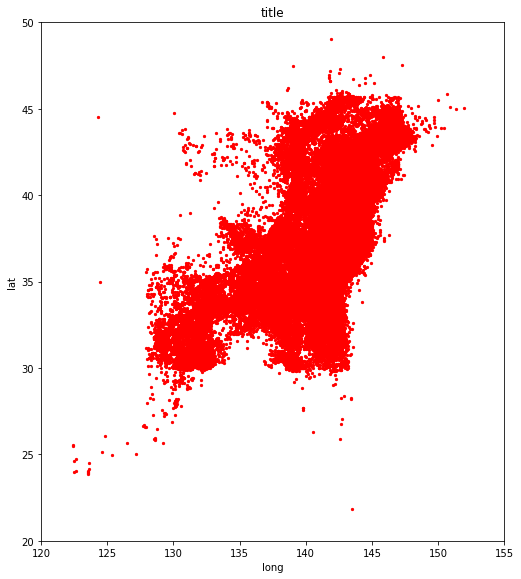

In [5]:
fig = plt.figure(figsize=(10.5 * m.cos(40 * m.pi / 180), 9))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['long'], data['lat'], color='red', marker='.', s=20)
plt.axis([120.0, 155.0, 20.0, 50.0])

axes.set_xlabel('long')
axes.set_ylabel('lat')
axes.set_title('title')

plt.show()

### Спроецируем Японию на плоскость

In [6]:
R_polus   = 6356.86
R_ekvator = 6378.20

def local_radius (longitude):
    return m.cos (longitude * m.pi / 180) * (R_ekvator - R_polus) + R_polus

R_japan = local_radius (37)

In [7]:
ORIGIN_LATITUDE  = 27.0
ORIGIN_LONGITUDE = 127.0

def spherical_to_cartesian (longitude, latitude):
    X = (longitude - ORIGIN_LONGITUDE) * m.pi / 180 * R_japan * m.cos (latitude * m.pi / 180)
    Y = (latitude  - ORIGIN_LATITUDE ) * m.pi / 180 * R_japan 
    
    return X, Y

data.shape

(247474, 10)

In [8]:
XY_massive = np.zeros((data.shape[0], 2))
j = 0
for i in tqdm(range (XY_massive.shape[0])):
    XY_massive[i][0], XY_massive[i][1] = spherical_to_cartesian (data['long'][i], data['lat'][i])

data['x'] = XY_massive[:, 0]
data['y'] = XY_massive[:, 1]
#data['lat'], data['long'] = spherical_to_cartesian (data['lat'], data['long'])

#### Посмотрим что получилось

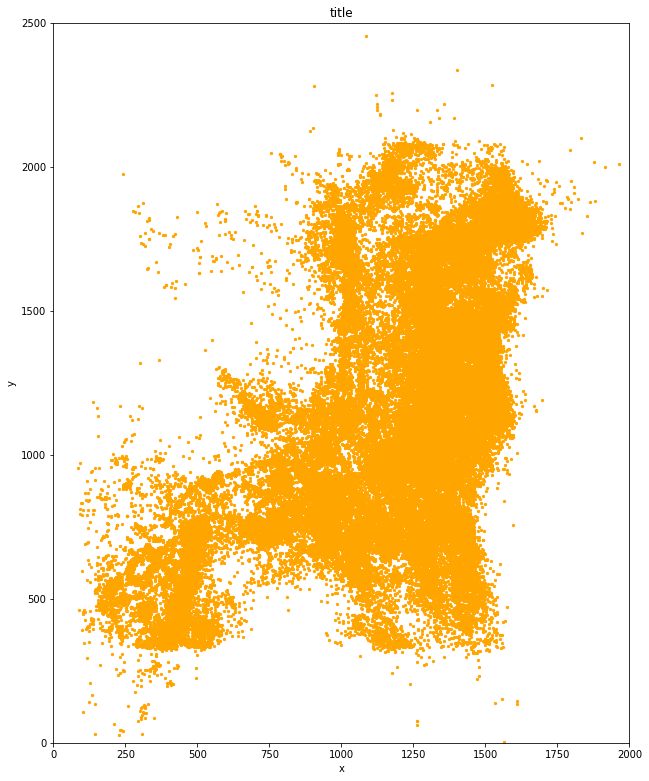

In [9]:
fig = plt.figure(figsize=(10, 12.5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['x'], data['y'], color='orange', marker='.', s=20)
plt.axis([0, 2000, 0, 2500])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('title')

if (SAVE_INFO == True):
    plt.savefig(EXPERIMENT_DIR + 'map.png', format='png', dpi=100)
plt.show()

In [10]:
a = np.zeros(20, dtype=int)
for i in tqdm(range (data.shape[0])):
    for threshold in range (20):
        if (data['class'][i] >= threshold/2) and (data['class'][i] < threshold/2 + 0.5):
            a[threshold] += 1
            break

            
# print ((a / data.shape[0] * 100).int())

    

#### Распечатаем сколько землетрясений и с какой амплитудой случалось

In [11]:
if (SAVE_INFO == True):
    distr_file = open (EXPERIMENT_DIR + 'earthquakes_distribution.txt', 'w')

for i in range (a.shape[0]):
    print ('from ', i/2, ' to ', i/2+0.5, ' : %.2f' % (a[i]/data.shape[0]*100), '% of dots')
    if (SAVE_INFO == True):
        print ('from ', i/2, ' to ', i/2+0.5, ' : %.2f' % (a[i]/data.shape[0]*100), '% of dots', file=distr_file)
        
if (SAVE_INFO == True):
    distr_file.close()


from  0.0  to  0.5  : 0.00 % of dots
from  0.5  to  1.0  : 0.00 % of dots
from  1.0  to  1.5  : 0.00 % of dots
from  1.5  to  2.0  : 0.00 % of dots
from  2.0  to  2.5  : 0.00 % of dots
from  2.5  to  3.0  : 51.02 % of dots
from  3.0  to  3.5  : 29.93 % of dots
from  3.5  to  4.0  : 11.94 % of dots
from  4.0  to  4.5  : 4.49 % of dots
from  4.5  to  5.0  : 1.65 % of dots
from  5.0  to  5.5  : 0.59 % of dots
from  5.5  to  6.0  : 0.23 % of dots
from  6.0  to  6.5  : 0.09 % of dots
from  6.5  to  7.0  : 0.03 % of dots
from  7.0  to  7.5  : 0.01 % of dots
from  7.5  to  8.0  : 0.00 % of dots
from  8.0  to  8.5  : 0.00 % of dots
from  8.5  to  9.0  : 0.00 % of dots
from  9.0  to  9.5  : 0.00 % of dots
from  9.5  to  10.0  : 0.00 % of dots


#### Посчитаем сколько дней прошло с 01.01.1990 до i-го землетрясения

In [12]:
time_massive = np.zeros (data.shape[0])

d_0 = dt.date (data['year'][0], data['month'][0], data['date'][0])
for i in tqdm(range (data.shape[0])):
    d_i = dt.date (data['year'][i], data['month'][i], data['date'][i])
    time_massive[i] = (d_i - d_0).days
    
data['time'] = time_massive

#### Посмотрим что имеем 

In [13]:
data

,year,month,date,hour,minute,seconds,lat,long,depth,class,x,y,time
0,1990,1,1,2,19,5.018,42.2734,144.8460,8.0,2.9,1469.001496,1699.098417,0.0
1,1990,1,1,4,4,20.026,39.9358,142.5461,30.6,3.0,1326.068924,1439.050722,0.0
2,1990,1,1,7,14,11.038,36.7053,141.2990,18.6,2.7,1275.297146,1079.671839,0.0
3,1990,1,1,9,3,12.039,36.4859,140.6964,67.2,4.3,1225.030854,1055.264556,0.0
4,1990,1,1,12,31,25.018,35.0121,138.1440,22.6,2.5,1015.369695,891.310804,0.0
5,1990,1,1,18,2,34.067,35.1802,136.5092,11.0,2.5,864.632781,910.011188,0.0
6,1990,1,1,23,52,50.070,39.8000,143.7200,0.0,3.0,1429.027552,1423.943571,0.0
7,1990,1,2,6,53,12.093,35.5828,141.2393,24.7,2.9,1288.276622,954.798663,1.0
8,1990,1,2,9,43,46.029,42.2963,142.3826,25.1,3.0,1265.765445,1701.645941,1.0
9,1990,1,2,10,4,50.086,39.6835,142.9171,34.0,3.4,1362.707004,1410.983460,1.0


## Разбиение датасета по дням и по клеткам в сетке

In [14]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2500

N_CELLS_HOR = 200
N_CELLS_VER = 250

In [15]:
print (data['time'][data.shape[0] - 1])
celled_data = torch.zeros ([int (data['time'][data.shape[0] - 1] + 1), 1, N_CELLS_HOR, N_CELLS_VER])
print (celled_data.shape)

cel_size_hor = (RIGHT_BORDER - LEFT_BORDER) / N_CELLS_HOR
cel_size_ver = (UP_BORDER    - DOWN_BORDER) / N_CELLS_VER

for i in tqdm(range (data.shape[0])):
    if (data['x'][i] > LEFT_BORDER) and (data['x'][i] < RIGHT_BORDER) and (data['y'][i] > DOWN_BORDER) and (data['y'][i] < UP_BORDER):
        x = int (data['x'][i] / cel_size_hor)
        y = int (data['y'][i] / cel_size_ver)
        celled_data[int(data['time'][i]), 0, x, y] = data['class'][i]
#         celled_data[int(data['time'][i]), 1, x, y] = data['depth'][i]

        
# celled_data
  
    

9590.0
torch.Size([9591, 1, 200, 250])


In [16]:
ACCURACY_RADIUS = 50

def create_celled_data_circled ():
    
    celled_data_cir = celled_data
    cel_R = (min(N_CELLS_HOR / (RIGHT_BORDER - LEFT_BORDER),
                 N_CELLS_VER / (UP_BORDER    - DOWN_BORDER))
             * ACCURACY_RADIUS)
    print (cel_R)
    
    for k in tqdm(range (data.shape[0])):
        if (data['x'][k] > LEFT_BORDER) and (data['x'][k] < RIGHT_BORDER) and (data['y'][k] > DOWN_BORDER) and (data['y'][k] < UP_BORDER):
            x = int (data['x'][k] / cel_size_hor)
            y = int (data['y'][k] / cel_size_ver)
            for i in range (max(0,
                                int(x - cel_R + 0.5)), 
                            min(celled_data_cir.shape[2],
                                int(x + cel_R + 0.5))):
                for j in range (max(0,
                                    int(y - cel_R + 0.5)), 
                                min(celled_data_cir.shape[3],
                                    int(y + cel_R + 0.5))):
                    if (m.sqrt((data['x'][k] - (i + 0.5) * cel_size_hor)**2 +
                               (data['y'][k] - (j + 0.5) * cel_size_ver)**2)
                        < ACCURACY_RADIUS):
                        celled_data_cir[int(data['time'][k]), 0, i, j] = \
                        max(celled_data_cir[int(data['time'][k]), 0, i, j], data['class'][k])
    
    return celled_data_cir

In [17]:
# celled_data_cir = create_celled_data_circled()
# torch.save(celled_data_cir, "Data/celled_data_cir_R=50_200x250")

In [18]:
celled_data_cir = torch.load("Data/celled_data_cir_R=50_200x250")

In [19]:
del data

In [20]:
print (celled_data.shape)
print (celled_data.dtype)

torch.Size([9591, 1, 200, 250])
torch.float32


In [21]:
freq_map = ((celled_data>0).sum(dim=0).float() / celled_data.shape[0]).unsqueeze(0)

In [22]:
print (freq_map.shape)

torch.Size([1, 1, 200, 250])


In [23]:
def show_one_day_image (tensor, day):
    plt.imshow (tensor[day].squeeze(0), cmap=plt.cm.afmhot_r)
    plt.colorbar()
    
def show_one_day_quakes (tensor, day):
    state = tensor[day]
    print (state.shape)
    X = []
    Y = []
    M = []
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if (state[i][j] != 0):
                X.append(i)
                Y.append(j)
                M.append(state[i][j].item())
#     print (X)
#     print (Y)
#     print (M)
    
    fig = plt.figure(figsize=(8, 10))
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.axis([0, state.shape[0], 0, state.shape[1]])
    axes.scatter(X, Y, s=500, c=M, marker='.', cmap=plt.cm.afmhot_r)
    plt.show
#     plt.colorbar()
    

torch.Size([200, 250])


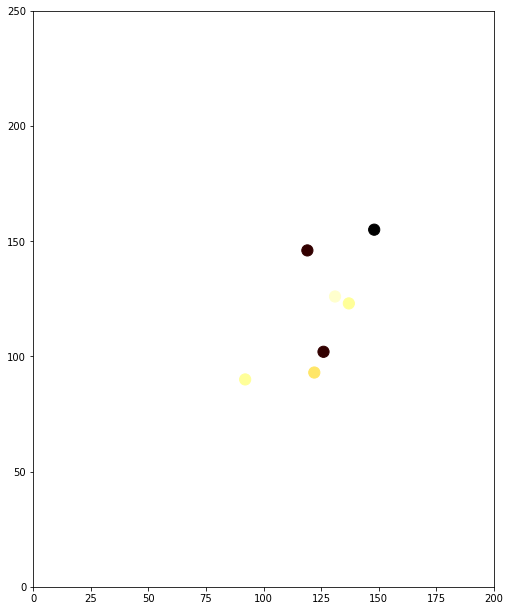

In [24]:
show_one_day_quakes (celled_data.squeeze(1), 500)

# Обучение

In [25]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
print (DEVICE)
# torch.cuda.set_device(DEVICE_ID)

cuda:0


In [26]:
def my_accuracy (input, target, threshold):
    true = ((input>threshold) == target)
    sum = torch.sum (true.float())
    return sum/input.shape[0]/input.shape[1]/input.shape[2]/input.shape[3]

def my_precision (input, target, threshold):
    TP = torch.sum (((input>threshold) * target      ).float())
    FP = torch.sum (((input>threshold) * (1 - target)).float())
    return TP / (TP + FP)

def my_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target).float())
    FN = torch.sum (((1 - (input>threshold)) * target).float())
    return TP / (TP + FN)

def my_precision_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target      ).float())
    FP = torch.sum ((     (input>threshold)  * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)) * target      ).float())
#     print ('TP = ', TP.item(), 'FP = ', FP.item(), 'FN = ', FN.item(), 'N = ', input.shape[0])
    return TP / (TP + FP), TP / (TP + FN)

def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((     (input>threshold) .float() * target      ).float())
    FP = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    TN = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def my_TP_FN_FP_TN (input, target, threshold):
    matrix = np.zeros((2, 2))
    matrix[0, 0] = torch.sum ((     (input>threshold) .float() * target      ).float())
    matrix[1, 0] = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    matrix[0, 1] = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    matrix[1, 1] = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return matrix / np.sum(matrix)

### Создадим датасет
#### (Может не влезть в оперативку (надо ~ 12Gb))

In [27]:
OBSERVED_DAYS = 64     # ~2 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

HEAVY_QUAKE_THRES = 5

In [28]:
class EarthquakeDataset_RNN_Train (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[idx],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)

class EarthquakeDataset_RNN_Test (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)

class EarthquakeDataset_RNN_Test_Cir (Dataset):
    def __init__(self, celled_data, celled_data_cir):
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.target = celled_data_cir[(celled_data.shape[0] -
                                       TESTING_DAYS):
                                      (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.target[(idx +
                                       DAYS_TO_PREDICT_AFTER):
                                      (idx +
                                       DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)


In [29]:
earthquakes_dataset_train = EarthquakeDataset_RNN_Train   (celled_data)
# earthquakes_dataset_test  = EarthquakeDataset_RNN_Test    (celled_data)
earthquakes_dataset_test  = EarthquakeDataset_RNN_Test_Cir(celled_data, celled_data_cir)

self.data : torch.Size([8591, 1, 200, 250])
size      : 8541
self.data : torch.Size([1000, 1, 200, 250])
size      : 950


In [30]:
earthquakes_dataloader_train = DataLoader(earthquakes_dataset_train,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

earthquakes_dataloader_test  = DataLoader(earthquakes_dataset_test,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

### Создадим саму сеть

In [31]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.CONV  = nn.Conv2d    (in_channels,
                                   out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   bias=False)             # think about it later
        
        self.BNORM =nn.BatchNorm2d(out_channels,
                                   eps=1e-05,
                                   momentum=0.1,
                                   affine=False)
#         self.RELU  = nn.ReLU ()
        
#         self.MAXPOOL = nn.MaxPool2d(3,
#                                     stride=1,
#                                     padding=1,
#                                     dilation=1)
        
    def forward(self, x):
        #print ('sizeof(x) = ', x.size())
        #print ('sizeof(xprev) = ', xprev.size())    
        
        x = self.CONV   (x)
        x = self.BNORM  (x)
#         x = self.RELU   (x)
#         x = self.MAXPOOL(x)
        
        return x

In [32]:
class RNNCell (nn.Module):
    
    def __init__(self, embedding_size=16, hidden_state_size=32):
        super(self.__class__,self).__init__()
        
        self.emb_size = embedding_size
        self.  h_size = hidden_state_size
        
        self.embedding  = ConvBlock (1, embedding_size, 3)
        self.RNN_update = nn.Sequential (ConvBlock (hidden_state_size + embedding_size,
                                                    hidden_state_size + embedding_size,
                                                    kernel_size=3),
                                         ConvBlock (hidden_state_size + embedding_size,
                                                    hidden_state_size,
                                                    kernel_size=3))
        self.RNN_to_result = nn.Sequential (ConvBlock (hidden_state_size + 1, 
                                                       2, 
                                                       kernel_size=3),
                                            nn.Softmax (dim=1))
        
    def forward (self, x, h_prev):
        
        x_emb   = self.embedding (x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
#         print ("x_and_h : ", x_and_h.shape)
        h_next  = self.RNN_update(x_and_h)
#         print ("h_prev :", h_prev.shape)
#         print ("h_next :", h_next.shape)
        
        assert h_prev.shape == h_next.shape
        
        h_next = F.tanh(h_next)
        return h_next, self.RNN_to_result(torch.cat([h_next, freq_map], dim=1))
    
    def init_state (self, batch_size, device=torch.device("cpu")):
        return torch.zeros(batch_size,
                           self.h_size,
                           N_CELLS_HOR, 
                           N_CELLS_VER,
                           requires_grad=False,
                           device=device)

### LSTM
![LSTM](./img/LSTM.png)

In [33]:
class HidFreqToRes (nn.Module):
    
    def __init__ (self,
                  hid_state_size=16,
                  additional_info_size=1):
        super(self.__class__,self).__init__()
        self.conv1   = ConvBlock(hid_state_size, 4, 3)
        self.ReLu    = nn.ReLU()
        self.conv2   = ConvBlock(4 + additional_info_size, 2, 3)
        self.SoftMax = nn.Softmax (dim=1)
        
    def forward (self, x, additional_info):
        x = self.ReLu(self.conv1 (x))
        return self.SoftMax(self.conv2(torch.cat([x, additional_info], dim=1)))

In [34]:
class LSTMCell (nn.Module):
    
    def __init__ (self,
                  embedding_size=16,
                  hidden_state_size=32):
        super(self.__class__,self).__init__()
        
        self.emb_size = embedding_size
        self.hid_size = hidden_state_size
        
#         self.embedding = ConvBlock (1, self.emb_size, kernel_size=3)
        self.embedding = nn.Sequential(ConvBlock(1,
                                                 self.emb_size,
                                                 3),
                                       nn.ReLU(),
                                       ConvBlock(self.emb_size,
                                                 self.emb_size,
                                                 3))
#         self.hidden_to_result = nn.Sequential (ConvBlock (hidden_state_size, 
#                                                           2, 
#                                                           kernel_size=3),
#                                                nn.Softmax (dim=1))
        self.hidden_to_result = HidFreqToRes (hidden_state_size,
                                              additional_info_size=1)
        
        self.f_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.i_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.c_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Tanh())
        self.o_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        
    def forward (self, x, prev_state):
        (prev_c, prev_h) = prev_state
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([prev_h, x_emb], dim=1)
        
        f_i = self.f_t(x_and_h)
        i_i = self.i_t(x_and_h)
        c_i = self.c_t(x_and_h)
        o_i = self.o_t(x_and_h)
        
        next_c = prev_c * f_i + i_i * c_i
        next_h = torch.tanh(next_c) * o_i
        
        assert prev_h.shape == next_h.shape
        assert prev_c.shape == next_c.shape
        
        return (next_c, next_h), self.hidden_to_result(next_h, freq_map)
        
    def init_state (self, batch_size, device=torch.device("cpu")):
        return (Variable(torch.zeros(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)),
                Variable(torch.zeros(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)))
               
    

#### Функция тренеровки

In [35]:
def train_network_RNN (RNN_cell,
                       device,
                       dataloader_train,
                       n_cycles=1,
                       learning_rate=0.0003,
                       earthquake_weight=1.,
                       lr_decay=1.):
    
    loss_massive = []
    i = 0
    
    RNN_cell.to(device)
    
    weights = torch.tensor([1., earthquake_weight], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weights)
    
    i = 0
    for cycle in range(n_cycles):
        
        optimizer = torch.optim.Adam(RNN_cell.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        
        hid_state = RNN_cell.init_state(batch_size=1, device=device)
        for data in tqdm(dataloader_train):
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
#             print ("inputs", inputs.shape)
#             print ("hid_state", hid_state.shape)
            hid_state, outputs = RNN_cell.forward(inputs, hid_state)
            
            loss = criterion(outputs, labels.squeeze(1).long())
            loss_massive.append(loss.item())
#             loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
#             print ("day : ", i, "loss : ", loss.item())
            
            if (type(hid_state) == tuple):
                for elem in hid_state:
                    elem.detach_()
            else:
                hid_state.detach_()
            
            if (i)%100==0:
                clear_output(True)
                print ("Done :", i, "/", dataloader_train.__len__())
                plt.plot(loss_massive,label='loss')
                plt.legend()
                plt.show()
            i += 1
        learning_rate /= lr_decay
         

In [36]:
N_CYCLES = 1
LEARNING_RATE = 0.0003
LR_DECAY = 10.
EARTHQUAKE_WEIGHT = 10000.

In [37]:
EMB_SIZE = 16
HID_SIZE = 32

Done : 8500 / 8541


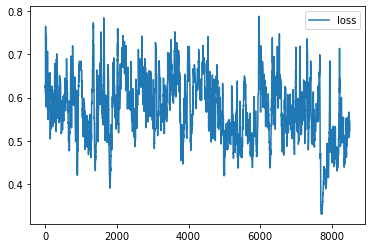

In [38]:
freq_map = freq_map.to(DEVICE)
# RNN_cell = RNNCell()
RNN_cell = LSTMCell(embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE)
train_network_RNN (RNN_cell,
                   DEVICE,
                   earthquakes_dataloader_train,
                   n_cycles=N_CYCLES,
                   learning_rate=LEARNING_RATE,
                   earthquake_weight=EARTHQUAKE_WEIGHT,
                   lr_decay=LR_DECAY
                   )

In [39]:
def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
        
    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1
        
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    print ("ROC_AUC_score = ", end='')
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)
    if (SAVE_INFO):
        print ('ROC_AUC               =', ROC_AUC_score, file=info_file)
    
    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)
    if (SAVE_INFO):
        print ('Average_precision     =', AVG_precision_score, file=info_file)
        
    print ('\n=======================')
    
    for threshold in (0.2, 0.4, 0.6, 0.8):
        print ('Threshold = ', threshold)
        print ('-----------------------')
        print (my_TP_FN_FP_TN(prediction, target, threshold))
        print ('=======================')
    
    if SAVE_INFO:
        print ('\n=======================', file=info_file)
    
        for threshold in (0.2, 0.4, 0.6, 0.8):
            print ('Threshold = ', threshold                    , file=info_file)
            print ('-----------------------'                    , file=info_file)
            print (my_TP_FN_FP_TN(prediction, target, threshold), file=info_file)
            print ('======================='                    , file=info_file)
    
    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)
    
#     precision = np.zeros(n_dots)
#     recall    = np.zeros(n_dots)
#     FPR       = np.zeros(n_dots)

    precision_massive = []
    recall_massive    = []
    FPR_massive       = []
    
    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())
    
    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Recall_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '^')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'ROC_curve.png', format='png', dpi=100)
    plt.show()
    
    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '^')
    axes.plot ((0, 1), (1, 0), 'grey', ls='--')
    
    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_Recall_curve.png', format='png', dpi=100)
    plt.show()
    
    return ROC_AUC_score, AVG_precision_score

In [40]:
def print_INFO_to_file(info_file):
        
    print ('ORIGIN_LATITUDE       =', ORIGIN_LATITUDE                       , file=info_file)
    print ('ORIGIN_LONGITUDE      =', ORIGIN_LONGITUDE                      , file=info_file)
    print ('LEFT_BORDER           =', LEFT_BORDER                           , file=info_file)
    print ('RIGHT_BORDER          =', RIGHT_BORDER                          , file=info_file)
    print ('DOWN_BORDER           =', DOWN_BORDER                           , file=info_file)
    print ('UP_BORDER             =', UP_BORDER                             , file=info_file)
    print ('N_CELLS_HOR           =', N_CELLS_HOR                           , file=info_file)
    print ('N_CELLS_VER           =', N_CELLS_VER                           , file=info_file)
    print (' '                                                              , file=info_file)
    print ('OBSERVED_DAYS         =', OBSERVED_DAYS                         , file=info_file)
    print ('DAYS_TO_PREDICT_AFTER =', DAYS_TO_PREDICT_AFTER                 , file=info_file)
    print ('DAYS_TO_PREDICT_BEFOR =', DAYS_TO_PREDICT_BEFORE                , file=info_file)
    print ('TESTING_DAYS          =', TESTING_DAYS                          , file=info_file)
    print ('HEAVY_QUAKE_THRES     =', HEAVY_QUAKE_THRES                     , file=info_file)
    print ('LEARNING_RATE         =', LEARNING_RATE                         , file=info_file)
    print ('LR_DECAY              =', LR_DECAY                              , file=info_file)
    print ('N_CYCLES              =', N_CYCLES                              , file=info_file)
    print ('EARTHQUAKE_WEIGHT     =', EARTHQUAKE_WEIGHT                     , file=info_file)
    print ('TRAIN_SHAPE           =', earthquakes_dataset_train.data.shape  , file=info_file)
    print ('TEST__SHAPE           =', earthquakes_dataset_test .data.shape  , file=info_file)
    print (' '                                                              , file=info_file)
    print ('EMB_SIZE              =', EMB_SIZE                              , file=info_file)
    print ('HID_SIZE              =', HID_SIZE                              , file=info_file)
    
    
#         print ('', , file=info_file)



ROC_AUC_score = 0.9316753787276996
AVG_precision_score = 0.08061596768081365

Threshold =  0.2
-----------------------
[[4.85331987e-03 8.51063957e-08]
 [9.95136744e-01 9.85106530e-06]]
Threshold =  0.4
-----------------------
[[4.53274449e-03 3.20659561e-04]
 [1.98225694e-01 7.96920902e-01]]
Threshold =  0.6
-----------------------
[[4.51774526e-03 3.35659617e-04]
 [1.87031003e-01 8.08115593e-01]]
Threshold =  0.8
-----------------------
[[4.50210619e-03 3.51297857e-04]
 [1.77945439e-01 8.17201157e-01]]


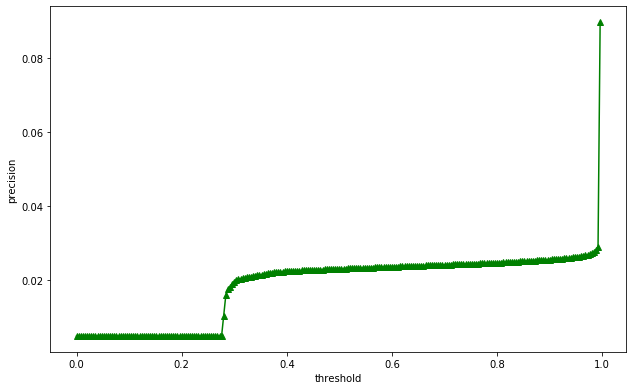

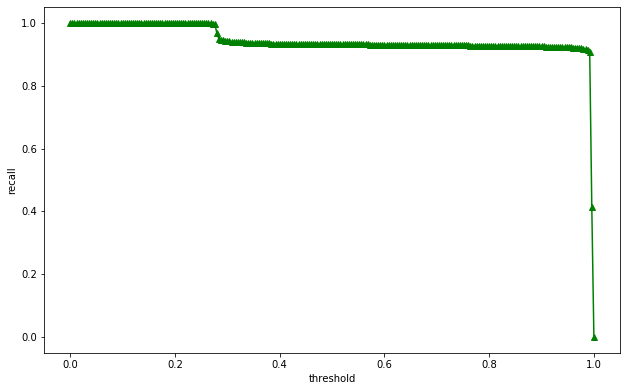

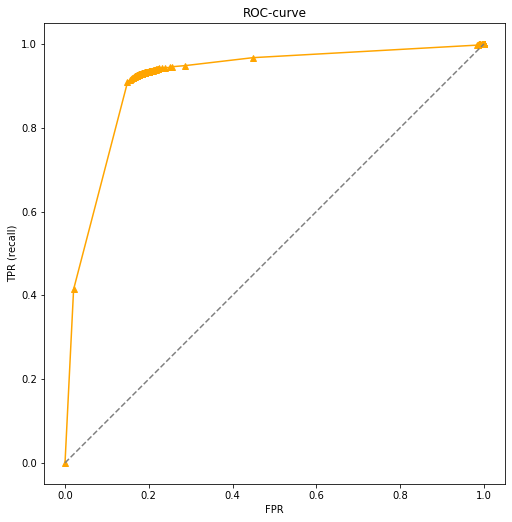

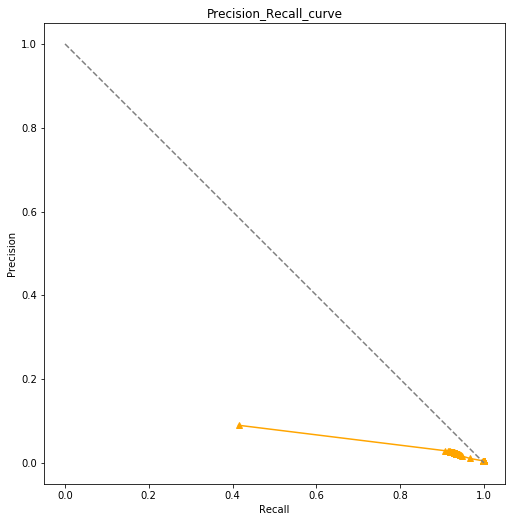

In [41]:
RNN_cell.eval()

if SAVE_INFO:
    info_file = open (EXPERIMENT_DIR + 'INFO.txt', 'w')
else:
    info_file = None

if SAVE_INFO:
    print_INFO_to_file(info_file)
    
ROC_AUC, AVG_prec = check_quality (RNN_cell,
                                   DEVICE,
                                   earthquakes_dataloader_test,
                                   n_dots=251,
                                   info_file=info_file)

if SAVE_INFO:
    info_file.close()


In [42]:
def compare_target_and_prediction (target, prediction):
    fig, axs = plt.subplots(ncols=2, nrows=1)
    
    X = []
    Y = []
    M = []
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            if (target[i][j] != 0):
                X.append(i)
                Y.append(j)
#                 M.append(target[i][j].item())
    
    print (X)
    print (Y)
#     print (M)
    
    axs[0].axis([0, target.shape[0], 0, target.shape[1]])
    axs[0].scatter(X, Y, s=200, marker='.', color='R')
    
    print (prediction.shape)
    axs[1].imshow(prediction.t(), cmap=plt.cm.afmhot_r, origin='lower')
    
    plt.show()

def visualise_info (RNN_cell,
                    device,
                    dataloader_test):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
        
    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1
        
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    print (prediction.shape)
    print (target.shape)
    
    prediction = prediction.cpu()
    target     = target    .cpu()
    
    i = 750
    compare_target_and_prediction(target[i], prediction[i])


torch.Size([940, 200, 250])
torch.Size([940, 200, 250])
[110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132]
[92, 93, 94, 95, 96, 90, 91, 92, 93, 94, 95, 96, 97, 90, 91, 92, 93, 94, 95, 96, 97, 98, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 89, 90, 91, 92, 93, 94,

/home/roma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


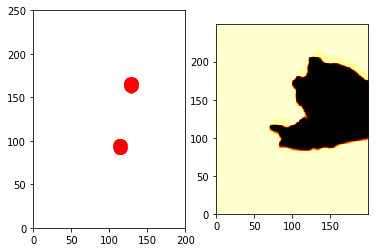

In [43]:
visualise_info(RNN_cell,
               DEVICE,
               earthquakes_dataloader_test)

In [44]:
A = torch.ones([2, 3])
A[: ,0] -= 1
A[: ,2] += 1

print (A)
print (A.t())

tensor([[0., 1., 2.],
        [0., 1., 2.]])
tensor([[0., 0.],
        [1., 1.],
        [2., 2.]])


In [45]:
def show_one_day_image (tensor, day):
    plt.imshow (tensor[day].squeeze(0), cmap=plt.cm.afmhot_r)
    plt.colorbar()
    
def show_one_day_quakes (tensor, day):
    state = tensor[day].squeeze(0)
    print (state.shape)
    X = []
    Y = []
    M = []
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if (state[i][j] != 0):
                X.append(i)
                Y.append(j)
                M.append(state[i][j].item())
    print (X)
    print (Y)
    print (M)
    
    fig = plt.figure(figsize=(8, 10))
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.axis([0, state.shape[0], 0, state.shape[1]])
    axes.scatter(X, Y, s=500, c=M, marker='.', cmap=plt.cm.Reds)
#     plt.colorbar()
    

In [46]:
dataset_usual   = EarthquakeDataset_RNN_Test    (celled_data)
dataset_circled = EarthquakeDataset_RNN_Test_Cir(celled_data, celled_data_cir)

dataloader_usual   = DataLoader(dataset_usual,
                                batch_size=1,
                                shuffle=False,
                                num_workers=1)
dataloader_circled = DataLoader(dataset_circled,
                                batch_size=1,
                                shuffle=False,
                                num_workers=1)

self.data : torch.Size([1000, 1, 200, 250])
size      : 950
self.data : torch.Size([1000, 1, 200, 250])
size      : 950


In [47]:
def positive_class_proportion(dataloader):
    pos_class = 0
    n_labels  = 0
            
    for data in tqdm(dataloader):

        labels = data[1].float()

        pos_class += labels.sum()
        n_labels  += labels.shape[0] * labels.shape[1] * labels.shape[2] * labels.shape[3]

#         print (pos_class)
#         print (n_labels)
    return pos_class / n_labels

In [48]:
print (positive_class_proportion(dataloader_usual  ))


tensor(0.0001)


In [49]:
print (positive_class_proportion(dataloader_circled))


tensor(0.0049)


In [50]:
# def train_network_CE (network, 
#                       device,
#                       dataloader_train,
#                       dataloader_test,
#                       epochs=200,
#                       learning_rate=0.1,
#                       earthquake_weight=1.):
    
#     if (SAVE_INFO == True):
#         epochs_file = open (EXPERIMENT_DIR + 'Epochs_info.txt', 'w')
    
#     loss_acc  = []
#     test_acc  = []
#     test_prec = []
#     test_rec  = []
#     net = network.to(device)

#     weights = torch.tensor([1., earthquake_weight], dtype = torch.float).to(device)
#     criterion = nn.CrossEntropyLoss(weights)
    
#     optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)

#     for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
#         if epoch == epochs/2:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/10, weight_decay=0.0001, momentum=0.9)
#             print ('Changed learning rate to ', learning_rate/10)
#         elif epoch == epochs*3/4:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/100, weight_decay=0.0001, momentum=0.9) 
#             print ('Changed learning rate to ', learning_rate/100)
            
#         net = net.train()        
#         epoch_accuracy = 0.0
#         epoch_elems = 0
#         for data in dataloader_train:
            
#             inputs = data[0].to(device)
#             labels = data[1].to(device)
# #             print ('inputs_shape = ', inputs.shape)
# #             print ('labels_shape = ', labels.shape)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
# #             print ('outputs : ', outputs.shape, outputs.dtype)
# #             print ('labels  : ', labels.shape , labels.dtype)
# #             outputs = torch.cat ((1-outputs, outputs), dim=1)
# #             print ('outputs ', outputs.shape, '   [', outputs[1, 0, 12, 12], outputs[1, 1, 12, 12], ']')
#             loss = criterion(outputs, labels.squeeze(1).long())
#             loss.backward()
#             optimizer.step()

# #             print (loss)
#             epoch_elems    += labels.shape[0]
#             epoch_accuracy += loss.item()*labels.shape[0]

#         epoch_accuracy /= epoch_elems
#         loss_acc.append(epoch_accuracy)
        
        
# #         calculating test accuracy, precision and recall
#         epoch_accuracy  = 0.0
#         epoch_precision = 0.0
#         epoch_recall    = 0.0
#         epoch_elems = 0
#         for data in dataloader_test:
#             inputs = data[0].to(device)
#             labels = data[1].to(device)   
#             outputs = net(inputs)
# #             find_mistake(outputs)
#             accuracy = my_accuracy (outputs[:, 1, :, :].unsqueeze(1), labels, 0.5)
#             precision, recall = my_precision_recall (outputs[:, 1, :, :].unsqueeze(1), labels, 0.5)
# #             accuracy2 = my_accuracy (outputs, labels, 1.0)
            
#             epoch_elems     += labels.shape[0]
#             epoch_accuracy  += accuracy.item()  * labels.shape[0]
#             epoch_precision += precision.item() * labels.shape[0]
#             epoch_recall    += recall.item()    * labels.shape[0]

# #         epoch_accuracy /= epoch_elems
#         test_acc .append (epoch_accuracy  / epoch_elems)
#         test_prec.append (epoch_precision / epoch_elems)
#         test_rec .append (epoch_recall    / epoch_elems)
        
        
#         print('Ep :', epoch,
#               'loss_tr :' , round (loss_acc [-1], 7),
#               'acc_ts :'  , round (test_acc [-1], 4),
#               'prec_ts :' , round (test_prec[-1], 4),
#               'rec_ts :'  , round (test_rec [-1], 4))
        
#         if (SAVE_INFO == True):
#             print('Ep :', epoch,
#                   'loss_tr :' , round (loss_acc [-1], 7),
#                   'acc_ts :'  , round (test_acc [-1], 4),
#                   'prec_ts :' , round (test_prec[-1], 4),
#                   'rec_ts :'  , round (test_rec [-1], 4)
#                   , file=epochs_file)


#     print('Finished Training')
    
# #     plt.plot(train_acc, label='Train')
#     plt.plot(loss_acc , label='Loss')
#     plt.legend()
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Loss_train.png', format='png', dpi=100)
#     plt.show()
    
#     plt.plot(test_acc , label='Test Accuracy')
#     plt.legend()
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Accuracy_test.png', format='png', dpi=100)
#     plt.show()
    
#     plt.plot(test_prec, label='Test Precision')
#     plt.legend()
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Precision_test.png', format='png', dpi=100)
#     plt.show()
    
#     plt.plot(test_rec , label='Test Recall')
#     plt.legend()
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Recall_test.png', format='png', dpi=100)
#     plt.show()
    
#     if (SAVE_INFO == True):
#         epochs_file.close()

In [51]:
# LEARNING_RATE = 0.1
# N_EPOCHS = 200
# EARTHQUAKE_WEIGHT = 10000.

# earthquake_network = ConvNetwork_CE ()
# train_network_CE  (earthquake_network,
#                    torch.device(DEVICE),
#                    earthquakes_dataloader_train,
#                    earthquakes_dataloader_test,
#                    epochs=N_EPOCHS,
#                    learning_rate=LEARNING_RATE,
#                    earthquake_weight=EARTHQUAKE_WEIGHT
#                    )

In [52]:
# def print_ROCinfo (model, dataLoader, device, alpha=0.5, n_dots=101):
#     model = model.to(device)
    
    
#     threshold_massive = np.linspace (0, n_dots-1, n_dots, dtype=int)
#     TP_massive = np.zeros (n_dots)
#     FP_massive = np.zeros (n_dots)
#     FN_massive = np.zeros (n_dots)
#     TN_massive = np.zeros (n_dots)
    
#     for data in dataLoader:
#         inputs = data[0].to(device)
#         labels = data[1].to(device)

#         outputs = model(inputs)
        
#         for threshold in threshold_massive:
#             prediction = (outputs[:, 1, :, :].unsqueeze(1))>(threshold/n_dots)
#             TP_massive[threshold] += torch.sum (prediction       * labels      ).float()
#             FP_massive[threshold] += torch.sum (prediction       * (1 - labels)).float()
#             FN_massive[threshold] += torch.sum ((1 - prediction) * labels      ).float()
#             TN_massive[threshold] += torch.sum ((1 - prediction) * (1 - labels)).float()
            
#     threshold_massive = threshold_massive / (n_dots-1)
#     precision_massive = TP_massive / (TP_massive + FP_massive)
#     TPR_massive       = TP_massive / (TP_massive + FN_massive)
#     FPR_massive       = FP_massive / (FP_massive + TN_massive)

#     sum_events = TP_massive[int(len(TP_massive)/2)] + FP_massive[int(len(FP_massive)/2)] + FN_massive[int(len(FN_massive)/2)] + TN_massive[int(len(TN_massive)/2)] 
#     print ('TP = ', round(TP_massive[int(len(TP_massive)/2)] / sum_events, 6), '%')
#     print ('FP = ', round(FP_massive[int(len(FP_massive)/2)] / sum_events, 6), '%')
#     print ('FN = ', round(FN_massive[int(len(FN_massive)/2)] / sum_events, 6), '%')
#     print ('TN = ', round(TN_massive[int(len(TN_massive)/2)] / sum_events, 6), '%')
    
#     if (SAVE_INFO == True):
#         print ('TP = ', round(TP_massive[int(len(TP_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
#         print ('FP = ', round(FP_massive[int(len(FP_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
#         print ('FN = ', round(FN_massive[int(len(FN_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
#         print ('TN = ', round(TN_massive[int(len(TN_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
    
#     # plot 1 precision
#     fig1 = plt.figure(figsize=(10, 6))

#     axes = fig1.add_axes([0.1, 0.1, 0.8, 0.8])

#     axes.plot(threshold_massive, precision_massive, color='green', marker='^')

#     axes.set_xlabel('threshold')
#     axes.set_ylabel('precision')

#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Precision_from_threshold.png', format='png', dpi=100)
#     plt.show()
    
#     # plot 2 recall
#     fig = plt.figure(figsize=(10, 6))

#     axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

#     axes.plot(threshold_massive, TPR_massive, color='green', marker='^')

#     axes.set_xlabel('threshold')
#     axes.set_ylabel('recall')
    
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Recall_from_threshold.png', format='png', dpi=100)
#     plt.show()
    
#     # plot 3 ROC-curve
#     fig = plt.figure(figsize=(8, 8))

#     axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

#     axes.plot(FPR_massive, TPR_massive, 'orange', marker = '^')
#     axes.plot (range(2), range(2), 'grey', ls='--')

#     axes.set_xlabel('FPR')
#     axes.set_ylabel('TPR (recall)')
#     axes.set_title('ROC-curve')

#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'ROC_curve.png', format='png', dpi=100)
#     plt.show()
    
#     del model
#     del inputs
#     del labels

In [53]:
# class ConvNetwork_MSE (nn.Module):
    
#     def __init__(self):
#         super(ConvNetwork_CE, self).__init__()
        
#         self.features = nn.Sequential()
        
#         self.features.add_module('conv1', conv_block(     OBSERVED_DAYS    , int (OBSERVED_DAYS/2 ), 3))
#         self.features.add_module('conv2', conv_block(int (OBSERVED_DAYS/2 ), int (OBSERVED_DAYS/4 ), 3))
#         self.features.add_module('conv3', conv_block(int (OBSERVED_DAYS/4 ), int (OBSERVED_DAYS/8 ), 3))
#         self.features.add_module('conv4', conv_block(int (OBSERVED_DAYS/8 ), int (OBSERVED_DAYS/16), 3))
#         self.features.add_module('conv5', conv_block(int (OBSERVED_DAYS/16),                      1, 3))
        
#         # might be a good idea to add an extra full connected layer
        
#     def forward(self, x):
# #         print ('input  : ', x.shape)
#         x = self.features(x)
# #         print ('output : ', x.shape)
#         return x
        

In [54]:
# def train_network_MSE(network, 
#                       device,
#                       dataloader_train,
#                       dataloader_test,
#                       epochs=164,
#                       learning_rate=0.1):
    
#     train_acc = []
#     test_acc  = []
#     net = network.to(device)

#     criterion = nn.MSELoss()
#     optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)

    
#     for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
#         if epoch == epochs/2:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/10, weight_decay=0.0001, momentum=0.9) 
#         elif epoch == epochs*3/4:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/100, weight_decay=0.0001, momentum=0.9) 
        
#         net = net.train()        
#         epoch_accuracy = 0.0
#         epoch_elems = 0
#         for data in dataloader_train:
            
#             inputs = data[0].to(device)
#             labels = data[1].to(device)
# #             print ('inputs_shape = ', inputs.shape)
# #             print ('labels_shape = ', labels.shape)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
# #             print ('outputs : ', outputs.dtype)
# #             print ('labels  : ', labels.dtype)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

# #             print (loss)
#             epoch_elems    += labels.shape[0]
#             epoch_accuracy += loss.item()*labels.shape[0]

#         epoch_accuracy /= epoch_elems
#         train_acc.append(epoch_accuracy)
        
        
#         # calculating test accuracy
#         epoch_accuracy = 0.0
#         epoch_elems = 0
#         for data in dataloader_test:
#             inputs = data[0].to(device)
#             labels = data[1].to(device)   
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
            
#             epoch_elems    += labels.shape[0]
#             epoch_accuracy += loss.item()*labels.shape[0]

#         epoch_accuracy /= epoch_elems
#         test_acc.append(epoch_accuracy)
        
        
#         print('Epoch : ', epoch, 'acc_train : ', round (train_acc[-1], 4), 'acc_test : ', round (test_acc[-1], 4))

#     print('Finished Training')
    
#     plt.plot(train_acc, label='Train')
#     plt.plot(test_acc , label='Test' )
#     plt.legend()
#     plt.grid()

In [55]:
# earthquake_netowrk = ConvNetwork_MSE ()
# train_network_MSE (earthquake_netowrk,
#                    torch.device(DEVICE),
#                    earthquakes_dataloader_train,
#                    earthquakes_dataloader_test,
#                    epochs=200,
#                    )

In [56]:
# def find_mistake (x):
#     assert (torch.sum((x < 0.0) + (x > 1.0)) == 0)

In [57]:
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# print ('input  : ', input.shape, input.dtype)
# print (input)
# print (torch.sum (input, dim = 0))
# print ('target : ', target.shape, target.dtype)
# print (target)
# output = loss(input, target)
# output.backward()

In [58]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class someDataset (Dataset):
#     def __init__(self):
#         self.data = torch.ones ([100, 32, 10, 10])
#         self.labels = torch.ones ([100, 1, 10, 10])
#         self.len  = self.data.shape[0]
        
#         print (self.data.shape)
#         print (self.labels.shape)
        
#     def __len__ (self):
#         return self.len
    
#     def __getitem__(self, idx):
#         print ('data_shape = ', self.data[idx].shape)
#         print ('result_shape = ', self.labels[idx].shape)
#         return self.data[idx], self.labels[idx]

In [59]:
# some_dataset = someDataset()
# dataloader = DataLoader (some_dataset,
#                          batch_size=32,
#                          shuffle=True,
#                          num_workers=1,
#                          )

# for i, batch in enumerate(dataloader, 0):
#     data = batch[0]
#     print (i, 'data ', data.shape)
#     labels = batch[1]
#     print (i, 'labels ', labels.shape)
    


# # eartquakes_dataloader_train = DataLoader(earthquakes_dataset_train,
# #                                          batch_size=33,
# #                                          shuffle=True,
# #                                          num_workers=4)
